In [3]:
import numpy as np
from jax import numpy as jnp, random
import jax
import matplotlib.pyplot as plt
from matplotlib import colormaps

rngs = random.split(random.PRNGKey(3), 2)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
normalize = lambda x: x / jnp.linalg.norm(x)


def plot(X, color, cmap="viridis", ax=None, include_mean=False):
    if ax is None:
        _fig, ax = plt.subplots()

    if type(color) is float:
        color = colormaps.get_cmap(cmap)(color)

    ax.scatter(X[:, 0], X[:, 1], color=color, s=20)
    if include_mean:
        mean_x = normalize(X.mean(0))
        ax.scatter(mean_x[0], mean_x[1], color=color, marker="x", s=100)
    ax.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
    # ax.axis("equal")


def self_attention(X, Q, K, V, beta):
    XQ = X @ Q.T
    XK = X @ K.T
    inners = XQ @ XK.T
    scores = jax.nn.softmax(inners * beta, axis=1)
    return scores @ (X @ V.T)


def sphere_project(vec, onto):
    return vec - jnp.dot(vec, onto) * onto


def p_self_attention(X, Q, K, V, beta):
    attention_out = self_attention(X, Q, K, V, beta)
    return jax.vmap(sphere_project, in_axes=(0, 0))(attention_out, X)


def simulate(X, Q, K, V, beta, eps, steps):
    if len(V.shape) == 2:
        V = jnp.tile(V, (steps, 1, 1))

    # The update function
    def update(X, V):
        X_updated = jax.vmap(normalize, 0)(X + eps * p_self_attention(X, Q, K, V, beta))
        return X_updated, X_updated

    # The first element is the carry, but we want all the elements
    Xs = jax.lax.scan(update, X, V)[1]

    return Xs


def dist_from_inner(inner):
    return jnp.sqrt(jax.nn.relu(1 - inner**2))


def get_inners(X):
    return X @ X.T


def make_inner_plot(Xs, ax=None):
    if ax is None:
        _fig, ax = plt.subplots()
    inners = jax.vmap(get_inners, 0)(Xs)
    total_inners = inners.sum([1, 2])
    ax.plot((total_inners), label=f"(n, d) = {(Xs.shape[1:])}")


def do_inner_experiment(n, d, ax=None):
    steps = int(2e3)
    eps = 1e-2
    X_init = random.normal(rngs[0], (n, d))
    # X_init = jnp.stack([jnp.cos(jnp.linspace(0, 2 * np.pi, n, endpoint=False)), jnp.sin(jnp.linspace(0, 2 * np.pi, n, endpoint=False))], axis=1)
    # X_init = jnp.stack([jnp.cos(jnp.linspace(0, 2 * np.pi, n, endpoint=False)), jnp.sin(jnp.linspace(0, 2 * np.pi, n, endpoint=False))], axis=1) + random.normal(rngs[0], (n, d)) * 0.05
    X_init = jax.vmap(normalize, 0)(X_init)
    Q = jnp.eye(d)
    K = jnp.eye(d)
    V = jnp.eye(d)
    Xs = simulate(X_init, Q, K, V, 1.0, eps, steps)

    make_inner_plot(Xs, ax)


def do_inner_experiments(ns, ds):
    fig, ax = plt.subplots()

    for n, d in zip(ns, ds):
        do_inner_experiment(n, d, ax)

    ax.legend()

In [18]:
n = 15
d = 2

steps = int(2e3)
eps = 1e-2
X_init = random.normal(rngs[0], (n, d))
# X_init = jnp.stack([jnp.cos(jnp.linspace(0, 2 * np.pi, n, endpoint=False)), jnp.sin(jnp.linspace(0, 2 * np.pi, n, endpoint=False))], axis=1)
# X_init = jnp.stack([jnp.cos(jnp.linspace(0, 2 * np.pi, n, endpoint=False)), jnp.sin(jnp.linspace(0, 2 * np.pi, n, endpoint=False))], axis=1) + random.normal(rngs[0], (n, d)) * 0.05
X_init = jax.vmap(normalize, 0)(X_init)
Q = jnp.eye(d)
K = jnp.eye(d)
V = -jnp.eye(d)
rotation_matrix = lambda theta : jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])
angles = jnp.linspace(0, 6 * np.pi, steps)
V = jax.vmap(rotation_matrix, 0)(angles)

Xs = simulate(X_init, Q, K, V, 1.0, eps, steps)

In [31]:
import matplotlib.pyplot as plt
import imageio.v3 as iio
from imageio import plugins

# Create a list to store all the images
images = []

n_frames = 100
steps_to_plot = steps
steps_per_frame = steps_to_plot // n_frames
# Loop over the range of images you want to create
for i in range(0, steps_to_plot, steps_per_frame):
    angle = angles[i]
    # Create a new figure and plot
    fig, ax = plt.subplots(figsize=(6, 5))
    plot(Xs[i], i / steps_to_plot, ax=ax, include_mean=False)
    ax.plot([0, jnp.cos(angle)], [0, jnp.sin(angle)], "gray")

    # Save the figure to a file
    filename = f'scratch_plots/plot_{i}.png'
    plt.savefig(filename)

    # Close the figure
    plt.close()

    # Append the filename to the images list
    images.append(iio.imread(filename))

# Save all images into a gif
iio.imwrite('movie.gif', images, plugin=plugins.pillow.PillowPlugin, loop=0)
# optimize('movie.gif')


In [16]:
steps_per_frame

100

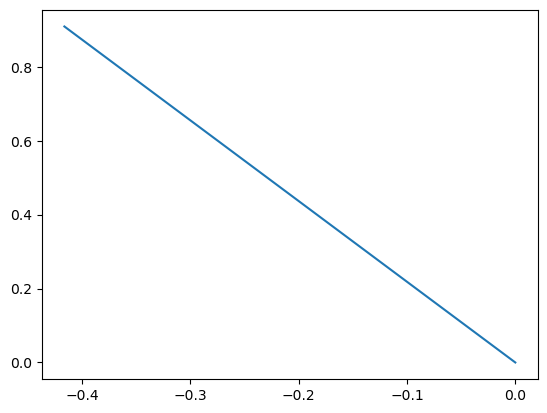

In [29]:
fig, ax = plt.subplots()
angle = 2